In [1]:
# Try 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from lsst.daf.persistence import Butler
from lsst.afw.image import abMagFromFlux, fluxFromABMag
from lsst.afw.table import MultiMatch
from lsst.meas.astrom import DirectMatchTask
import lsst.daf.persistence as daf_persistence
import pandas
import os
import glob, sys

from astropy.coordinates import SkyCoord
from astropy import units as u

import healpy as hp

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Stealing tbe butler code from HCS_colorcolor.ipynb
depth = 'DEEP' #use the DEEP catalog, got this file path from another notebook
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

In [3]:
tract = 10054
band = 'HSC-R'

In [4]:
patch = '0,0'
sources = butler.get('deepCoadd_meas', tract=tract, patch=patch, filter=band)
subset = butler.subset('deepCoadd_meas', filter=band, tract=tract, patch=patch)

In [5]:
sources['coord_ra'], sources['coord_dec']

(array([2.61099674, 2.61092744, 2.61079699, ..., 2.61017199, 2.60958772,
        2.60959261]),
 array([0.05025443, 0.05025856, 0.05024888, ..., 0.05240874, 0.05283503,
        0.05283339]))

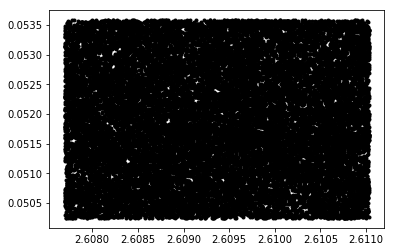

In [6]:
plt.plot(sources['coord_ra'], sources['coord_dec'], 'k.')

In [7]:
# Set up a catalog
matched_cat = MultiMatch(sources.schema, {"tract": np.int64})
# Try to add the sources to it
matched_cat.add(sources,{"tract": 10054})

In [8]:
np.degrees(0.052), np.degrees(2.6095)

(2.979380534680281, 149.51333663938834)

In [9]:
# XXX--upon further research, MultiMatch is not really the right tool for this job. JIRA says 
# it is only a quick-and-dirty type of code and we should really just use astropy for simple
# catalog matching.

In [10]:
# GAIA stuff in /project/shared/data/gaia_dr2
path = '/project/shared/data/gaia_dr2'
file_guess = 'GaiaSource_3848200193665853184_3848584747857767040.csv.gz'
filepath = os.path.join(path, file_guess)

In [11]:
gaia_data = pandas.read_csv(filepath, compression='gzip')

In [12]:
gaia_cat = SkyCoord(gaia_data['ra']*u.deg, gaia_data['dec']*u.deg)

In [13]:
hsc_cat = SkyCoord(sources['coord_ra']*u.rad, sources['coord_dec']*u.rad)

In [14]:
idx, d2d, d3d = gaia_cat.match_to_catalog_sky(hsc_cat)

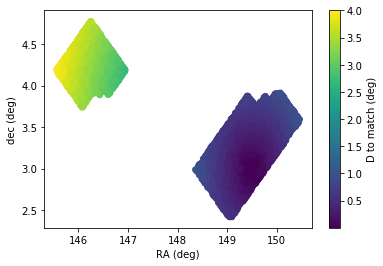

In [15]:
plt.scatter(gaia_data['ra']*u.deg, gaia_data['dec']*u.deg, c=d2d)
cb = plt.colorbar()
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')
cb.set_label('D to match (deg)')

In [16]:
# go through the Gaia files and figure out a lookup for healpix
nside = 256
hpids = np.arange(hp.nside2npix(nside))

In [17]:
filenames = glob.glob(path+'/*.gz')

In [18]:
len(filenames)

61234

In [19]:
#hp2gaiafile = {}
#for i in hpids:
#    hp2gaiafile[i] = []

In [20]:
names = ['hpid', 'filenames']
dtypes = [int, '|U500']
hp2gaiafile = np.zeros(hpids.size, dtype=list(zip(names, dtypes)))

In [21]:
# Build a lookup dictionary
for filename in filenames[0:1]:
    gaia_data = pandas.read_csv(filename, compression='gzip')
    lat = np.pi / 2.0 - np.radians(gaia_data['dec'])
    hpix = hp.ang2pix(nside, lat, np.radians(gaia_data['ra']))
    uhpix = np.unique(hpix)
    for hpix in uhpix:
        hp2gaiafile['filenames'][hpix] += ', '+(os.path.basename(filename))
        
#np.savez('gaia_match_out/hp2gaiafile.npz', hp2gaiafile=hp2gaiafile)

In [22]:
##np.save('hp2gaiafile.npz', hp2gaiafile)

In [23]:
#np.where(hp2gaiafile['filenames'] != '')

In [ ]:
# ok, that's taking up Gb for some reason. Let's try just doing the filename dict

# Looking at about 10hr to read in all this.
gaiafile2hpid = {}
max_i = float(len(filenames))
i=0
last_floor = 0
for filename in filenames:
    gaia_data = pandas.read_csv(filename, compression='gzip')
    lat = np.pi / 2.0 - np.radians(gaia_data['dec'])
    hpix = hp.ang2pix(nside, lat, np.radians(gaia_data['ra']))
    uhpix = np.unique(hpix)
    gaiafile2hpid[os.path.basename(filename)] = uhpix.tolist()
    per = np.floor(i/max_i*100)
    if per != last_floor:
        print(per)
        last_floor = per
    i += 1


1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0


In [ ]:
np.savez('filename2hpid_%i.npz'%nside, gaiafile2hpid=gaiafile2hpid)